In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

In [3]:
key = 'XXX' # Bing Search API Key

In [4]:
#??search_images_bing

In [8]:
results = search_images_bing(key, 'touching face')
ims = results.attrgot('content_url')
ims[0]

'https://www.chivmen.com/wp-content/uploads/2018/04/dont-touch-face.jpg'

In [9]:
image_classes = 'touching', 'not_touching'
search_terms = {'touching': 'touching face', 'not_touching':'Person face'}
path = Path('face')

In [25]:
if not path.exists():
    path.mkdir()
    for o in image_classes:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, search_terms[o])
        download_images(dest, urls=results.attrgot('content_url'))

In [26]:
fns = get_image_files(path)
fns

(#294) [Path('face/touching/00000001.jpg'),Path('face/touching/00000008.jpg'),Path('face/touching/00000004.jpg'),Path('face/touching/00000003.jpg'),Path('face/touching/00000006.jpg'),Path('face/touching/00000000.jpg'),Path('face/touching/00000012.JPG'),Path('face/touching/00000011.jpg'),Path('face/touching/00000010.jpg'),Path('face/touching/00000014.jpg')...]

In [27]:
failed = verify_images(fns)
failed

(#0) []

In [28]:
failed.map(Path.unlink);

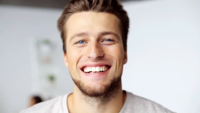

In [30]:
img = Image.open('face/not_touching/00000032.jpg')
img.to_thumb(200, 200)

## Making the DataLoader

In [177]:
face_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [178]:
dls = face_data_block.dataloaders(path)

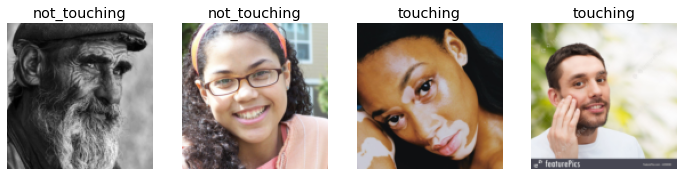

In [179]:
dls.valid.show_batch(max_n=4, nrows=1) # Default

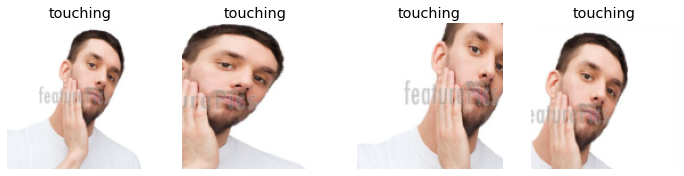

In [180]:
face_data_block.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = face_data_block.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

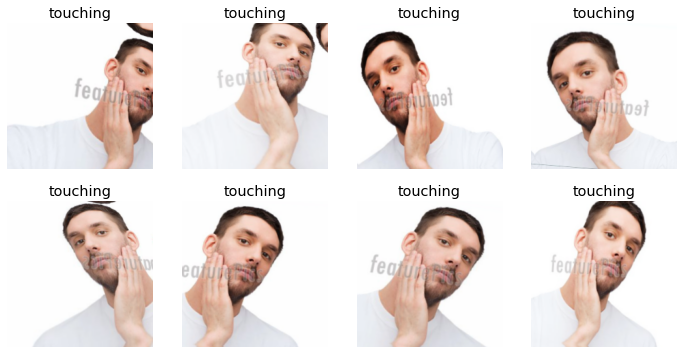

In [181]:
face_data_block.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms()) # Best way
dls = face_data_block.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [182]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.101857,0.427876,0.192308,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.617401,0.291960,0.115385,00:05
1,0.457437,0.149780,0.038462,00:05
2,0.368297,0.045201,0.000000,00:05
3,0.297133,0.046496,0.019231,00:05
4,0.242668,0.054706,0.019231,00:05
5,0.205389,0.057500,0.038462,00:05


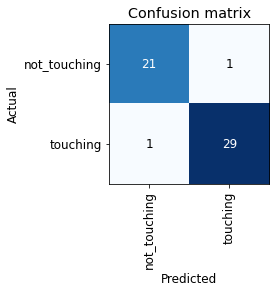

In [183]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

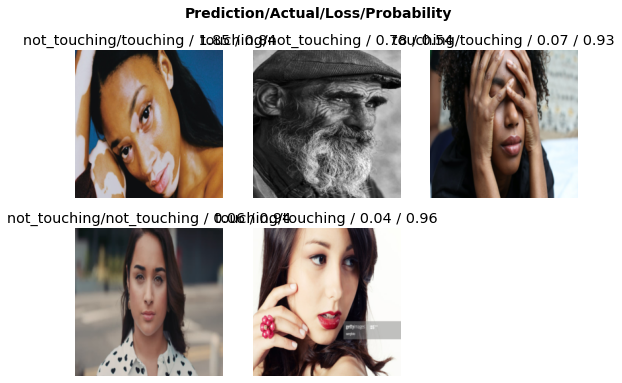

In [184]:
interp.plot_top_losses(5, nrows=2)

In [185]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [176]:
for idx in cleaner.delete():
    print("#")
    cleaner.fns[idx].unlink()

#


In [98]:
# Use this cell resolve name conflicts
!mv face/not_touching/00000108.jpg face/not_touching/00000168.jpg

In [119]:
for idx,cat in cleaner.change():
    print("#")
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [186]:
learn.export()

## Inference

In [4]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [5]:
learn_inf = load_learner(path/'export.pkl')

In [6]:
learn_inf.predict('./face/touching/00000143.jpg')

('touching', tensor(1), tensor([7.3882e-04, 9.9926e-01]))

In [7]:
learn_inf.dls.vocab

(#2) ['not_touching','touching']

## Making a GUI App

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [1]:
img = PILImage.create(btn_upload.data[-1])
img

In [21]:
learn_inf.predict(img)

('touching', tensor(1), tensor([9.8805e-05, 9.9990e-01]))

In [32]:
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

Output()

In [33]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Please choose an image'
lbl_pred

Label(value='Please choose an image')

In [34]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)    

In [36]:
VBox([widgets.Label('Are you touching your face?'), 
     btn_upload, btn_run, out_pl, lbl_pred])